# Code for making predictions with and without news features

## Libraries/Data required

In [21]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [288]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

# We're missing IPC values; I fill in previous IPC values based on time.
ipc_orig = df['ipc'] # Create copy of ipc column
df.insert(5, column='ipc_orig', value=ipc_orig) # Insert copy of ipc column
# fill in missing ipc values with ffill for each district
df['ipc'] = df.groupby(level=1)['ipc'].ffill()
# TODO: make visualisation of how many IPC values are missing.

78


## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

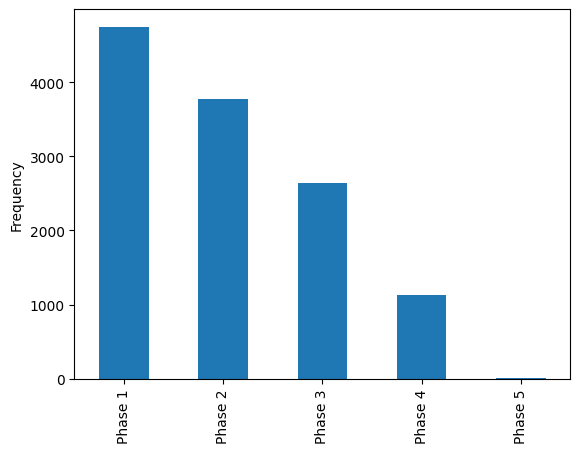

In [23]:
ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

C:\Users\20203527\AppData\Local\Temp\ipykernel_24020\480331542.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world


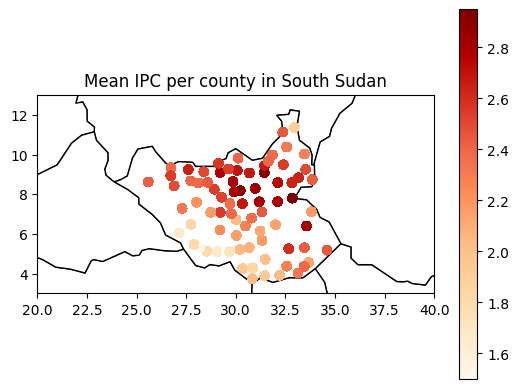

In [24]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [25]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [26]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [28]:
# Baseline with no news articles.
# Standard parameters that ZHL has created.
# Create several lagged columns to use as explanatory variables for the model
# All these columns are newly added.
df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'ipc_orig',
       'year', 'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

In [29]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

In [30]:
X = df.iloc[:, -6:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()
train_accuraccy = list()
test_accuraccy = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']); # Plot confusion matrix

    # Calculate accuraccy
    train_correct = ((results.predict(X_train).round()==y_train['ipc']).sum()) # ammount of correct train predictions
    test_correct = ((y_pred.round()==y_val['ipc']).sum()) # ammount of correct test predictions
    train_values_count = len(y_train['ipc'])-results.predict(X_train).round().isna().sum() # train values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
    test_values_count = len(y_val['ipc'])-y_val['ipc'].isna().sum() # test values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values

    # Append accuraccy to respective lists
    train_accuraccy.append(train_correct/train_values_count)
    test_accuraccy.append(test_correct/test_values_count)
    print(f"train accuraccy instant: {train_correct/train_values_count}")
    print(f"test accuracy instant: {test_correct/test_values_count}")
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
print(f"Mean train accuraccy: {np.mean(train_accuraccy):.2f}") # Print train accuraccy
print(f"Mean test accuraccy: {np.mean(test_accuraccy):.2f}") # Print test accuraccy

ValueError: zero-size array to reduction operation maximum which has no identity

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [31]:
# Reads all the news articles
# Baseline with news articles
base_news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
base_news_df["date"] = pd.to_datetime(
    pd.to_datetime(base_news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",  # Articles don't have a day, everything is set to 1.
)
base_news_df.head()

,summary,date,location_article,lat,lng,hunger,refugees,humanitarian,conflict
0,The article discusses the passing of the new C...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False
1,The article discusses the military actions tak...,2011-07-01,Abyei,9.838551,28.486396,False,False,False,False
2,The article discusses the signing of a Framewo...,2011-06-01,Southern Kordofan,11.036544,30.895824,False,False,False,False
3,The article discusses the upcoming independenc...,2011-07-01,South Sudan,6.876992,31.306979,False,False,False,False
4,The article discusses the need for South Sudan...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False


### New data

LDA data

In [35]:
news_lda_df = pd.read_csv("final_output_lda.csv") # Read news data into DataFrame

# Create date column
news_lda_df["date"] = pd.to_datetime(
    pd.to_datetime(news_lda_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_lda_df.head()

,date,Unnamed: 0,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,2011-07-01,Doc0,0.00,0.00,0.00,0.29,0.12,0.0,0.00,0.45,0.00,0.12
1,2011-07-01,Doc1,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.41,0.09,0.49
2,2011-06-01,Doc2,0.15,0.07,0.67,0.00,0.00,0.0,0.00,0.09,0.00,0.00
3,2011-07-01,Doc3,0.00,0.04,0.00,0.00,0.21,0.0,0.00,0.35,0.20,0.18
4,2011-07-01,Doc4,0.00,0.00,0.00,0.00,0.00,0.0,0.77,0.00,0.00,0.22


In [36]:
pd.set_option('display.max_columns', None) # Display all columns in DataFrame

Rake paragraphs

In [37]:
news_rp_df = pd.read_csv("df_rake_paragraphs.csv") # Read news data into DataFrame

# Create date column
news_rp_df["date"] = pd.to_datetime(
    pd.to_datetime(news_rp_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_rp_df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords,['government'],['people'],['juba'],['president'],['state'],['peace'],['security'],['international'],['conflict'],['year'],['national'],['united'],['war'],['political']
0,0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...",True,False,False,False,False,False,False,False,False,False,True,False,False,False
1,1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...","['article', 'discusses', 'need', 'south', 'sud...","['juba', '—', 'vice', 'president', 'soon', 'in...",False,False,False,False,False,False,False,True,False,False,False,False,False,False


Rake summary

In [38]:
news_rs_df = pd.read_csv("df_rake_summary.csv") # Read news data into DataFrame

# Create date column
news_rs_df["date"] = pd.to_datetime(
    pd.to_datetime(news_rs_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_rs_df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords,['government'],['president'],['peace'],['juba'],['conflict'],['security'],['violence'],['international'],['un'],['support'],['humanitarian'],['oil'],['war'],['machar']
0,0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...",True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...","['article', 'discusses', 'need', 'south', 'sud...","['juba', '—', 'vice', 'president', 'soon', 'in...",False,False,False,False,False,False,False,True,False,False,False,False,False,False


Yake paragraphs

In [39]:
news_yp_df = pd.read_csv("df_yake_paragraphs.csv") # Read news data into DataFrame

# Create date column
news_yp_df["date"] = pd.to_datetime(
    pd.to_datetime(news_yp_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_yp_df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords,['juba'],['abyei'],['president'],['machar'],['Uganda'],['jonglei'],['darfur'],['nile'],['minister'],['nuer'],['khartoum'],['government'],['police'],['ethiopia']
0,0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '...",False,False,False,False,False,False,True,False,False,False,True,False,False,False
2,2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ...",False,False,False,False,False,False,True,False,False,False,True,False,False,False
3,3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world...",False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...","['article', 'discusses', 'need', 'south', 'sud...","['juba', '—', 'vice', 'president', 'soon', 'in...",False,False,False,False,False,False,False,False,False,False,False,False,False,False


Yake summary

In [40]:
news_ys_df = pd.read_csv("df_yake_summary.csv") # Read news data into DataFrame

# Create date column
news_ys_df["date"] = pd.to_datetime(
    pd.to_datetime(news_ys_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_ys_df.head()

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords,['president'],['jonglei'],['uganda'],['abyei'],['machar'],['united'],['bor'],['ethiopia'],['republic'],['ababa'],['bentiu'],['malakal'],['kenya'],['unity']
0,0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...",False,False,False,False,False,False,False,False,True,False,False,False,False,True
1,1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world...",False,False,False,False,False,False,False,False,True,False,False,False,False,True
4,4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...","['article', 'discusses', 'need', 'south', 'sud...","['juba', '—', 'vice', 'president', 'soon', 'in...",False,False,False,False,False,False,False,False,False,False,False,False,False,False


Chatgpt

In [41]:
news_gpt_df = pd.read_csv("df_gpt.csv") # Read news data into DataFrame

# Create date column
news_gpt_df["date"] = pd.to_datetime(
    pd.to_datetime(news_gpt_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_gpt_df.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,['Independence'],['Secession'],['Conflict'],['Famine'],['Peace'],['Refugees'],['Ethnicity'],['UNMISS'],['SPLA'],['Oil'],['Displacement'],['Children'],['Referendum'],['Instability'],['Clashes'],['Drought'],['Corruption'],['Mediation'],['Crisis'],['Rebel']
0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...",False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...",True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [42]:
def create_news_features(input_news_df, columns):
    '''Generates the percentage of news articles per month that mention a certain topic. with a rolling mean
    '''
    cols = []
    for column in columns:
        col = input_news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

In [291]:
news_rs_df

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords,['government'],['president'],['peace'],['juba'],['conflict'],['security'],['violence'],['international'],['un'],['support'],['humanitarian'],['oil'],['war'],['machar']
0,0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('Sudan', 0.006790420531629885)]","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...",True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South', 0.005956356779761904)]","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern', 0.018753573430078812)]","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South', 0.007468538638409145)]","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world...",False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,4,4,4,4,The article discusses the need for South Sudan...,Juba,The article discusses the need for South Sudan...,2011-07-01,4.859363,31.571250,Juba — The Vice President of the soon-to-be in...,Sudan Tribune,"['South Sudan', 'East Africa', 'Business', 'Ex...","[('order', 0.0737025008366585)]","[('Sudan', 0.00826034811578811)]","[('South Sudan', 0.0162607999296675), ('Act Bi...","['article', 'discusses', 'need', 'south', 'sud...","['juba', '—', 'vice', 'president', 'soon', 'in...",False,False,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18501,18501,18501,18501,18501,18501,The article discusses the successful delivery ...,Maiwut Primary Health Care Centre,The article discusses the successful delivery ...,2023-04-01,8.606200,33.924100,When Grace* arrived at the Maiwut Primary Heal...,International Committee of the Red Cross (Geneva),"['Aid and Assistance', 'East Africa', 'South S...","[('Sudan', 0.054876396262831695)]","[('Annet', 0.02574232209957891)]","[('Monoji Juan', 0.003434004739340046), ('Maiw...","['article', 'discusses', 'successful', 'delive...","['grac

In [107]:
# # country wide news features
# Choose the columns that will be used for the predictions
news_features_base = create_news_features(base_news_df, [base_news_df.columns[-4:]])  # The last x are the keywords.
news_features_lda = create_news_features(news_lda_df, [news_lda_df.columns[-10:]])
news_features_rp = create_news_features(news_rp_df, [news_rp_df.columns[-14:]])
news_features_rs = create_news_features(news_rs_df, [news_rs_df.columns[-14:]])
news_features_yp = create_news_features(news_yp_df, [news_yp_df.columns[-14:]])
news_features_ys = create_news_features(news_ys_df, [news_ys_df.columns[-14:]])
news_features_gpt = create_news_features(news_gpt_df, [news_gpt_df.columns[-20:]])
news_features_base

,hunger,refugees,humanitarian,conflict
date,,,,
2011-06-01,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-12-01,0.022222,0.027778,0.044444,4.625929e-18
2023-01-01,0.022222,0.027778,0.044444,4.625929e-18
2023-02-01,0.083333,0.027778,0.041667,4.625929e-18


In [292]:
df

,,country,district_code,centx,centy,year_month,ipc_orig,year,month,ipc,ha,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,count_violence,sum_fatalities,food_price_idx,area,cropland_pct,pop,ruggedness_mean,pasture_pct
date,district,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-01,Bor,South Sudan,74,32.00486,6.465644,2007_01,NaN,2007,1,NaN,NaN,0.345851,114.3253,0.253903,-0.107226,0.671249,0.048880,0,0,0.561363,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-02-01,Bor,South Sudan,74,32.00486,6.465644,2007_02,NaN,2007,2,NaN,NaN,0.307600,119.8153,1.018789,0.133927,0.129184,-0.457928,0,0,0.565693,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-03-01,Bor,South Sudan,74,32.00486,6.465644,2007_03,NaN,2007,3,NaN,NaN,0.278344,110.3800,2.001045,-2.164728,1.025460,-0.590175,0,0,0.592437,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-04-01,Bor,South Sudan,74,32.00486,6.465644,2007_04,NaN,2007,4,NaN,NaN,0.303320,102.3160,12.831140,-0.332849,3.846809,-1.845536,0,0,0.605352,14008.3300,7.961984,239344.0,11393.760,90.8503
2007-05-01,Bor,South Sudan,74,32.00486,6.465644,2007_05,NaN,2007,5,NaN,NaN,0.413716,97.1873,19.274320,0.288466,8.316274,-2.972735,0,0,0.618699,14008.3300,7.961984,239344.0,11393.760,90.8503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-01,Malakal,South Sudan,151,31.64280,9.658457,2019_10,3.0,2019,10,3.0,0.0,0.681990,113.3705,14.913800,2.580618,22.853360,6.053181,1,0,82.872570,757.7855,13.068690,102228.0,7145.909,85.5000
2019-11-01,Malakal,South Sudan,151,31.64280,9.658457,2019_11,NaN,2019,11,3.0,NaN,0.556748,116.7530,0.645686,-0.091687,13.372410,8.745254,0,0,87.728720,757.7855,13.068690,102228.0,7145.909,85.5000
2019-12-01,Malakal,South Sudan,151,31.64280,9.658457,2019_12,NaN,2019,12,3.0,NaN,0.400063,117.5583,0.046705,-0.000951,3.089540,1.698060,0,0,93.566750,757.7855,13.068690,102228.0,7145.909,85.5000


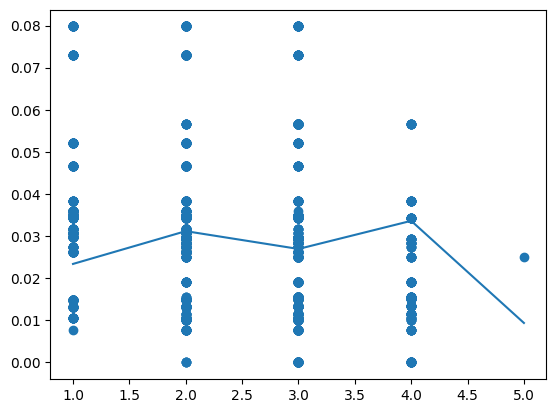

In [296]:
# Test cell, same as in the function below.
ndf = df.copy()
ndf.sort_index(level=0, inplace=True) # Sort DataFrame by date
ndf = ndf.iloc[ndf['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
# Locations do not matter to us; every district has the same topic value.
ndf = ndf.join(news_features_base, how="left") # Join df with created news features
ndf.dropna(subset=ndf.iloc[:,-len(news_features_base.columns):].columns, inplace=True)
# ndf = ndf[ndf['ipc'] != 5]
# ndf = ndf[ndf.index.get_level_values(0) >= '2015-01-01']
ndf

x = ndf['ipc_orig']
y = ndf['conflict']
plt.scatter(x, y)
#plot mean hunger per ipc
vals = ndf.groupby('ipc_orig').mean()  #TODO: why is the mean so high when the values aren't? 
plt.plot(vals['humanitarian'])

In [243]:
ndf['ipc'].value_counts()

3.0    2498
2.0    1449
4.0     607
1.0     278
5.0       4
Name: ipc, dtype: int64

# Logistic Regression

## Topics + Baseline features

In [268]:
def train_model(features_df):
    """
    Takes dataframe with keywords as input and returns the MAE, R2, train accuraccy and test accuraccy for each number of features.
    """
    ndf = df.copy()
    ndf.sort_index(level=0, inplace=True) # Sort DataFrame by date
    ndf = ndf.iloc[ndf['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
    ndf = ndf.join(features_df, how="left") # Join df with created news features
    ndf = ndf.iloc[ndf.iloc[:,-1].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
    ndf.dropna(subset=ndf.iloc[:,-len(features_df.columns):].columns, inplace=True)
    ndf = ndf[ndf['ipc'] != 5]

    all_mae_values = list()
    all_r2_values = list()
    all_train_accuraccy = list()
    all_test_accuraccy = list()

    # Loops over the keywords, goes from 1 topic to all the topics
    # This still contains the 6 baseline keywords.
    for i in range(len(features_df.columns)+1):
        start = -len(features_df.columns)-6
        end = -len(features_df.columns) + i
        print(f"Start: {start}, End: {end}")
        if end == 0:
            X = ndf.iloc[:, start:] # Define explanatory variables
        else:
            X = ndf.iloc[:, start:(end)] # Define explanatory variables
        y = ndf[["ipc"]] # Define target data

        cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

        # Initinalize empty lists to score scores
        mae_values = list()
        r2_values = list()
        train_accuraccy = list()
        test_accuraccy = list()

        for train_index, val_index in cv.split(X): # Loop over the different training-test splits

            # Define X and y data
            X_train, X_test = X.iloc[train_index], X.iloc[val_index]
            y_train, y_test = y.iloc[train_index], y.iloc[val_index]

            # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
            X_train = X_train.dropna(axis=1, how='all').copy()
            X_test = X_test[X_train.columns]
            
            #Interpolate training data to generate more training points. Makes sure there are no NaN values in the training data.
            X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.ffill())
            X_train.reset_index(level=0, drop=True, inplace=True)
            y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.ffill())
            y_train.reset_index(level=0, drop=True, inplace=True)

            # Initialising of logistic regression model.
            model = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')

            results = model.fit(X_train, y_train.values.ravel()) # Get model results on training data

            #for looking at how the model performs closer
            #print(results.summary()) # Print model summary

            y_pred_test = results.predict(X_test) # Run model on test data
            y_pred_train = results.predict(X_train) # Run model on test data
            
            # Append results to respective lists
            mae_values.append(metrics.mean_absolute_error(y_test, y_pred_test))

            # for looking at how the model performs closer
            # plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
            # plot_ConfusionMatrix(prediction = y_pred_test, true = y_test['ipc']) # Plot confusion matrix

            train_accuraccy.append(metrics.accuracy_score(y_train, y_pred_train))
            test_accuraccy.append(metrics.accuracy_score(y_test, y_pred_test))
            r2_values.append(results.score(X_test, y_test))
        
        print(f"Number of features: {len(X.columns)-1}")
        print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
        print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
        print(f"Mean train accuraccy: {np.mean(train_accuraccy):.2f}") # Print train accuraccy
        print(f"Mean test accuraccy: {np.mean(test_accuraccy):.2f}") # Print test accuraccy
        print(f"Mean train accuraccy: {np.mean(train_accuraccy)}") # Print train accuraccy
        print(f"Mean test accuraccy: {np.mean(test_accuraccy)}")
        print('-------------------------')

        all_mae_values.append(np.mean(mae_values))
        all_r2_values.append(np.mean(r2_values))
        all_train_accuraccy.append(np.mean(train_accuraccy))
        all_test_accuraccy.append(np.mean(test_accuraccy))
    print("")
    print(f"All MAE values: {all_mae_values}")
    print(f"All R2 values: {all_r2_values}")
    print(f"All train accuracy values: {all_train_accuraccy}")
    print(f"All test accuracy values: {all_test_accuraccy}")
    return all_mae_values, all_r2_values, all_train_accuraccy, all_test_accuraccy

### Running models

In [269]:
base_mae_values, base_r2_values, base_train_accuracy, base_test_accuracy = train_model(news_features_base)
lda_mae_values, lda_r2_values, lda_train_accuracy, lda_test_accuracy = train_model(news_features_lda)
rp_mae_values, rp_r2_values, rp_train_accuracy, rp_test_accuracy = train_model(news_features_rp)
rs_mae_values, rs_r2_values, rs_train_accuracy, rs_test_accuracy = train_model(news_features_rs)
yp_mae_values, yp_r2_values, yp_train_accuracy, yp_test_accuracy = train_model(news_features_yp)
ys_mae_values, ys_r2_values, ys_train_accuracy, ys_test_accuracy = train_model(news_features_ys)
gpt_mae_values, gpt_r2_values, gpt_train_accuracy, gpt_test_accuracy = train_model(news_features_gpt)

Start: -10, End: -4
Number of features: 5
Mean MAE: 0.29
Mean R2: 0.72
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8590887933758704
Mean test accuraccy: 0.7230177059276367
-------------------------
Start: -10, End: -3
Number of features: 6
Mean MAE: 0.29
Mean R2: 0.72
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8590426241402751
Mean test accuraccy: 0.7244033872209392
-------------------------
Start: -10, End: -2
Number of features: 7
Mean MAE: 0.29
Mean R2: 0.72
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8589810691075945
Mean test accuraccy: 0.7237875288683603
-------------------------
Start: -10, End: -1
Number of features: 8
Mean MAE: 0.29
Mean R2: 0.72
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8593171278931419
Mean test accuraccy: 0.7237875288683603
-------------------------
Start: -10, End: 0
Number of features: 9
Mean MAE: 0.29
Mean R2: 0.72
Mean t

### Plotting topics + baseline features

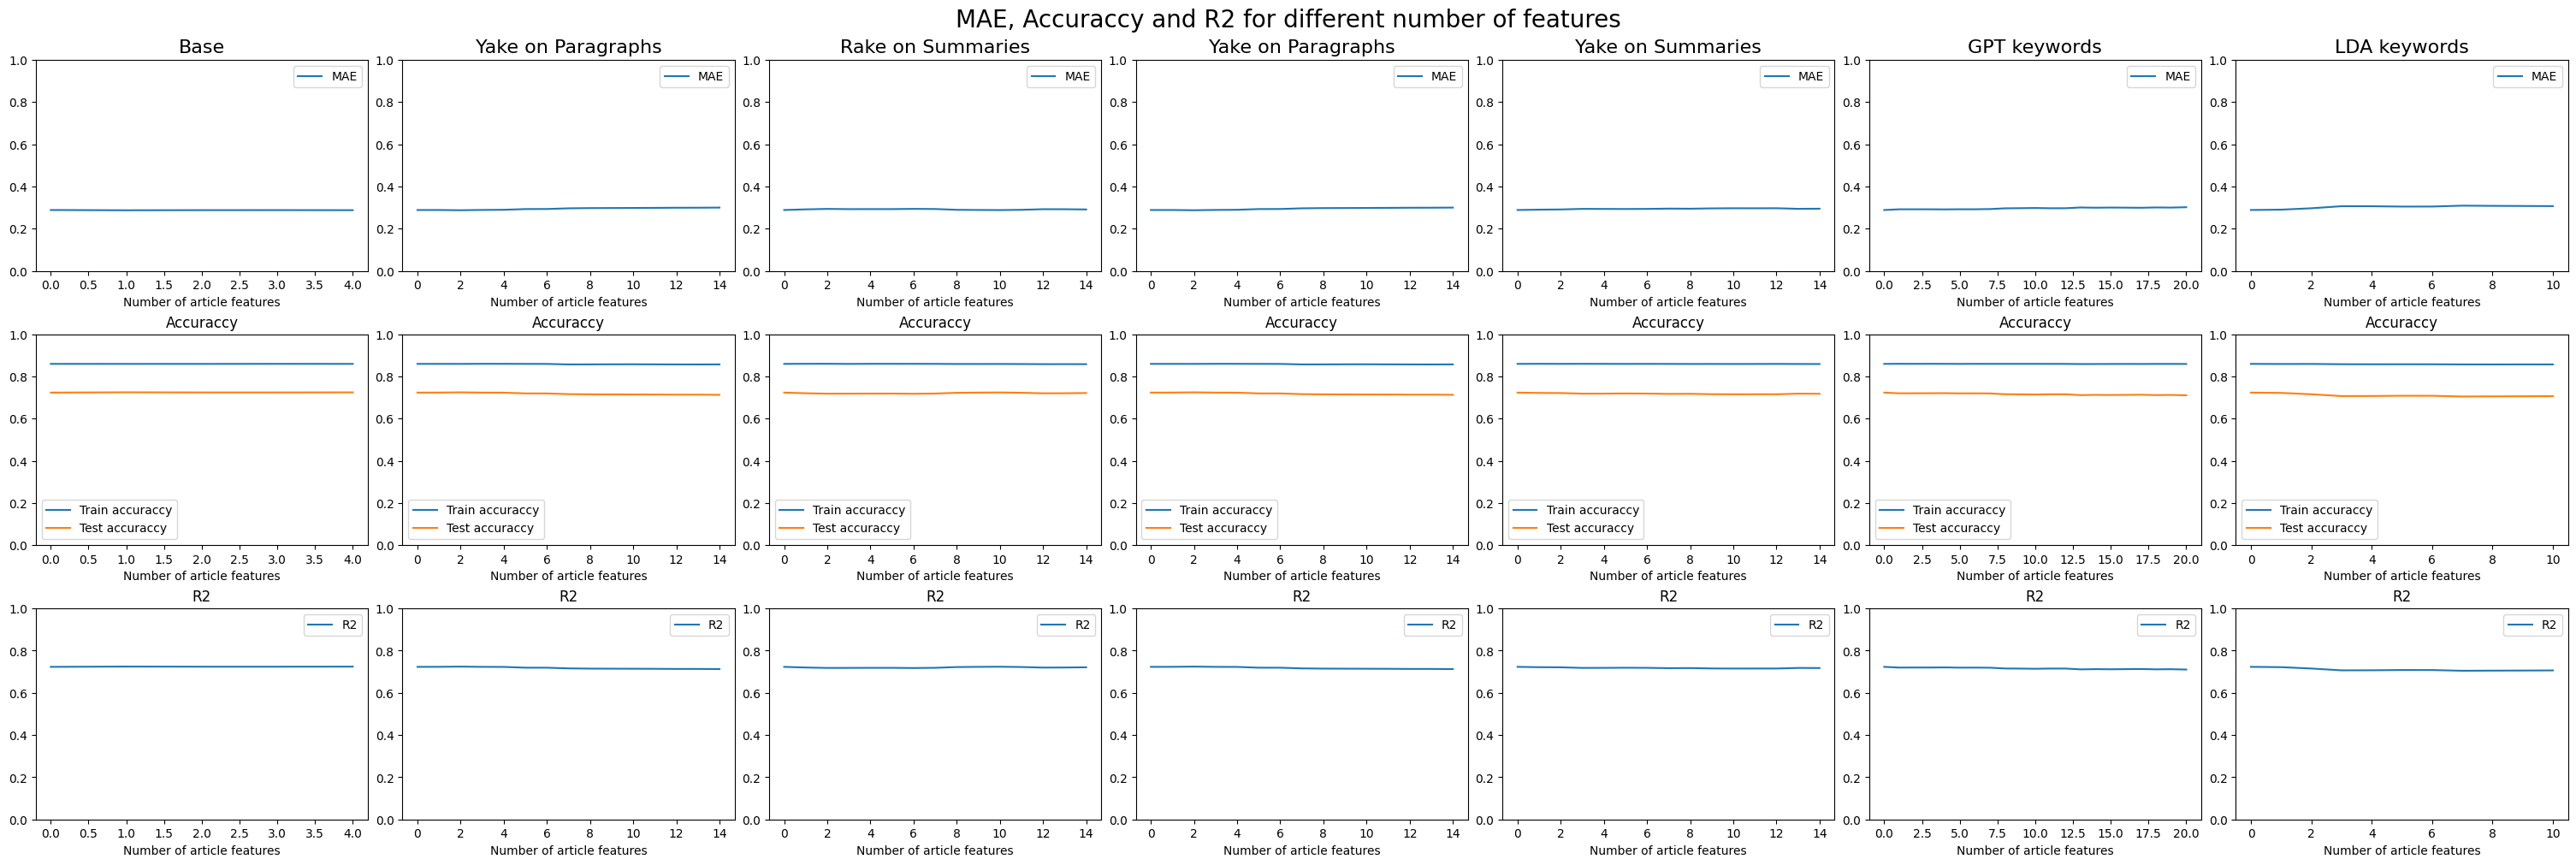

In [ ]:
#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(30, 10), constrained_layout=True)

axis[0,0].plot(base_mae_values, label='MAE')
axis[2,0].plot(base_r2_values, label='R2')
axis[1,0].plot(base_train_accuracy, label='Train accuraccy')
axis[1,0].plot(base_test_accuracy, label='Test accuraccy')
axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[0,0].set_title('MAE')
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of article features')
axis[1,0].set_xlabel('Number of article features')
axis[2,0].set_xlabel('Number of article features')
axis[0,0].set_ylim(0, 1)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(yp_mae_values, label='MAE')
axis[2,1].plot(yp_r2_values, label='R2')
axis[1,1].plot(yp_train_accuracy, label='Train accuraccy')
axis[1,1].plot(yp_test_accuracy, label='Test accuraccy')
axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[0,1].set_title('MAE')
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of article features')
axis[1,1].set_xlabel('Number of article features')
axis[2,1].set_xlabel('Number of article features')
axis[0,1].set_ylim(0, 1)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(rs_mae_values, label='MAE')
axis[2,2].plot(rs_r2_values, label='R2')
axis[1,2].plot(rs_train_accuracy, label='Train accuraccy')
axis[1,2].plot(rs_test_accuracy, label='Test accuraccy')
axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[0,2].set_title('MAE')
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of article features')
axis[1,2].set_xlabel('Number of article features')
axis[2,2].set_xlabel('Number of article features')
axis[0,2].set_ylim(0, 1)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(yp_mae_values, label='MAE')
axis[2,3].plot(yp_r2_values, label='R2')
axis[1,3].plot(yp_train_accuracy, label='Train accuraccy')
axis[1,3].plot(yp_test_accuracy, label='Test accuraccy')
axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of article features')
axis[1,3].set_xlabel('Number of article features')
axis[2,3].set_xlabel('Number of article features')
axis[0,3].set_ylim(0, 1)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(ys_mae_values, label='MAE')
axis[2,4].plot(ys_r2_values, label='R2')
axis[1,4].plot(ys_train_accuracy, label='Train accuraccy')
axis[1,4].plot(ys_test_accuracy, label='Test accuraccy')
axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[0,4].set_title('MAE')
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of article features')
axis[1,4].set_xlabel('Number of article features')
axis[2,4].set_xlabel('Number of article features')
axis[0,4].set_ylim(0, 1)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_mae_values, label='MAE')
axis[2,5].plot(gpt_r2_values, label='R2')
axis[1,5].plot(gpt_train_accuracy, label='Train accuraccy')
axis[1,5].plot(gpt_test_accuracy, label='Test accuraccy')
axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[0,5].set_title('MAE')
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of article features')
axis[1,5].set_xlabel('Number of article features')
axis[2,5].set_xlabel('Number of article features')
axis[0,5].set_ylim(0, 1)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_mae_values, label='MAE')
axis[2,6].plot(lda_r2_values, label='R2')
axis[1,6].plot(lda_train_accuracy, label='Train accuraccy')
axis[1,6].plot(lda_test_accuracy, label='Test accuraccy')
axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[0,6].set_title('MAE')
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 1)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

## Only Topics

In [ ]:
def train_model_only_articles(features_df):

    ndf = df.copy()
    ndf.sort_index(level=0, inplace=True) # Sort DataFrame by date
    ndf = ndf.iloc[ndf['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
    ndf = ndf.join(features_df, how="left") # Join df with created news features
    ndf = ndf.iloc[ndf.iloc[:,-1].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
    ndf.dropna(subset=ndf.iloc[:,-len(features_df.columns):].columns, inplace=True)
    ndf = ndf[ndf['ipc'] != 5]

    all_mae_values = list()
    all_r2_values = list()
    all_train_accuraccy = list()
    all_test_accuraccy = list()

    for i in range(len(features_df.columns)):
        start = -len(features_df.columns)
        end = -len(features_df.columns) + i + 1
        print(f"Start: {start}, End: {end}")
        if end == 0:
            X = ndf.iloc[:, start:] # Define explanatory variables
        else:
            X = ndf.iloc[:, start:(end)] # Define explanatory variables
        y = ndf[["ipc"]] # Define target data

        cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

        # Initinalize empty lists to score scores
        mae_values = list()
        r2_values = list()
        train_accuraccy = list()
        test_accuraccy = list()

        for train_index, val_index in cv.split(X): # Loop over the different training-test splits

            # Define X and y data
            X_train, X_test = X.iloc[train_index], X.iloc[val_index]
            y_train, y_test = y.iloc[train_index], y.iloc[val_index]

            # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
            X_train = X_train.dropna(axis=1, how='all').copy()
            X_test = X_test[X_train.columns]
            
            #Interpolate training data to generate more training points
            X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.ffill())
            X_train.reset_index(level=0, drop=True, inplace=True)
            y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.ffill())
            y_train.reset_index(level=0, drop=True, inplace=True)

            model = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')

            results = model.fit(X_train, y_train.values.ravel()) # Get model results on training data

            #for looking at how the model performs closer
            #print(results.summary()) # Print model summary

            y_pred_test = results.predict(X_test) # Run model on test data
            y_pred_train = results.predict(X_train) # Run model on test data
            
            # Append results to respective lists
            mae_values.append(metrics.mean_absolute_error(y_test, y_pred_test))
            # r2_values.append(results.rsquared)

            # for looking at how the model performs closer
            # plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
            # plot_ConfusionMatrix(prediction = y_pred_test, true = y_test['ipc']) # Plot confusion matrix
        
            # Append accuraccy to respective lists
            train_accuraccy.append(metrics.accuracy_score(y_train, y_pred_train))
            test_accuraccy.append(metrics.accuracy_score(y_test, y_pred_test))
            r2_values.append(results.score(X_test, y_test))
        
        print(f"Number of features: {len(X.columns)-1}")
        print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
        print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
        print(f"Mean train accuraccy: {np.mean(train_accuraccy):.2f}") # Print train accuraccy
        print(f"Mean test accuraccy: {np.mean(test_accuraccy):.2f}") # Print test accuraccy
        print(f"Mean train accuraccy: {np.mean(train_accuraccy)}") # Print train accuraccy
        print(f"Mean test accuraccy: {np.mean(test_accuraccy)}")
        print('-------------------------')

        all_mae_values.append(np.mean(mae_values))
        all_r2_values.append(np.mean(r2_values))
        all_train_accuraccy.append(np.mean(train_accuraccy))
        all_test_accuraccy.append(np.mean(test_accuraccy))
    print("")
    print(f"All MAE values: {all_mae_values}")
    print(f"All R2 values: {all_r2_values}")
    print(f"All train accuracy values: {all_train_accuraccy}")
    print(f"All test accuracy values: {all_test_accuraccy}")
    return all_mae_values, all_r2_values, all_train_accuraccy, all_test_accuraccy

### Running models

In [ ]:
base_mae_values_articles, base_r2_values_articles, base_train_accuracy_articles, base_test_accuracy_articles = train_model_only_articles(news_features_base)
rp_mae_values_articles, rp_r2_values_articles, rp_train_accuracy_articles, rp_test_accuracy_articles = train_model_only_articles(news_features_rp)
rs_mae_values_articles, rs_r2_values_articles, rs_train_accuracy_articles, rs_test_accuracy_articles = train_model_only_articles(news_features_rs)
rs_mae_values_articles, rs_r2_values_articles, rs_train_accuracy_articles, rs_test_accuracy_articles = train_model_only_articles(news_features_rs)
yp_mae_values_articles, yp_r2_values_articles, yp_train_accuracy_articles, yp_test_accuracy_articles = train_model_only_articles(news_features_yp)
ys_mae_values_articles, ys_r2_values_articles, ys_train_accuracy_articles, ys_test_accuracy_articles = train_model_only_articles(news_features_ys)
gpt_mae_values_articles, gpt_r2_values_articles, gpt_train_accuracy_articles, gpt_test_accuracy_articles = train_model_only_articles(news_features_gpt)
lda_mae_values_articles, lda_r2_values_articles, lda_train_accuracy_articles, lda_test_accuracy_articles = train_model_only_articles(news_features_lda)

Start: -4, End: -3
Number of features: 0
Mean MAE: 1.48
Mean R2: 0.71
Mean train accuraccy: 0.35
Mean test accuraccy: 0.18
Mean train accuraccy: 0.345786620073125
Mean test accuraccy: 0.18090839107005388
-------------------------
Start: -4, End: -2
Number of features: 1
Mean MAE: 1.29
Mean R2: 0.78
Mean train accuraccy: 0.40
Mean test accuraccy: 0.22
Mean train accuraccy: 0.3986398508471234
Mean test accuraccy: 0.22047729022324863
-------------------------
Start: -4, End: -1
Number of features: 2
Mean MAE: 1.54
Mean R2: 0.79
Mean train accuraccy: 0.41
Mean test accuraccy: 0.18
Mean train accuraccy: 0.4136719509844583
Mean test accuraccy: 0.17859892224788299
-------------------------
Start: -4, End: 0
Number of features: 3
Mean MAE: 1.27
Mean R2: 0.84
Mean train accuraccy: 0.46
Mean test accuraccy: 0.24
Mean train accuraccy: 0.4604651572626374
Mean test accuraccy: 0.23849114703618168
-------------------------

All MAE values: [1.4801089556342242, 1.290493323870055, 1.5370613308350507, 1

### Plotting only topics

Text(0.5, 0.98, 'MAE, Accuraccy and R2 for different number of features')

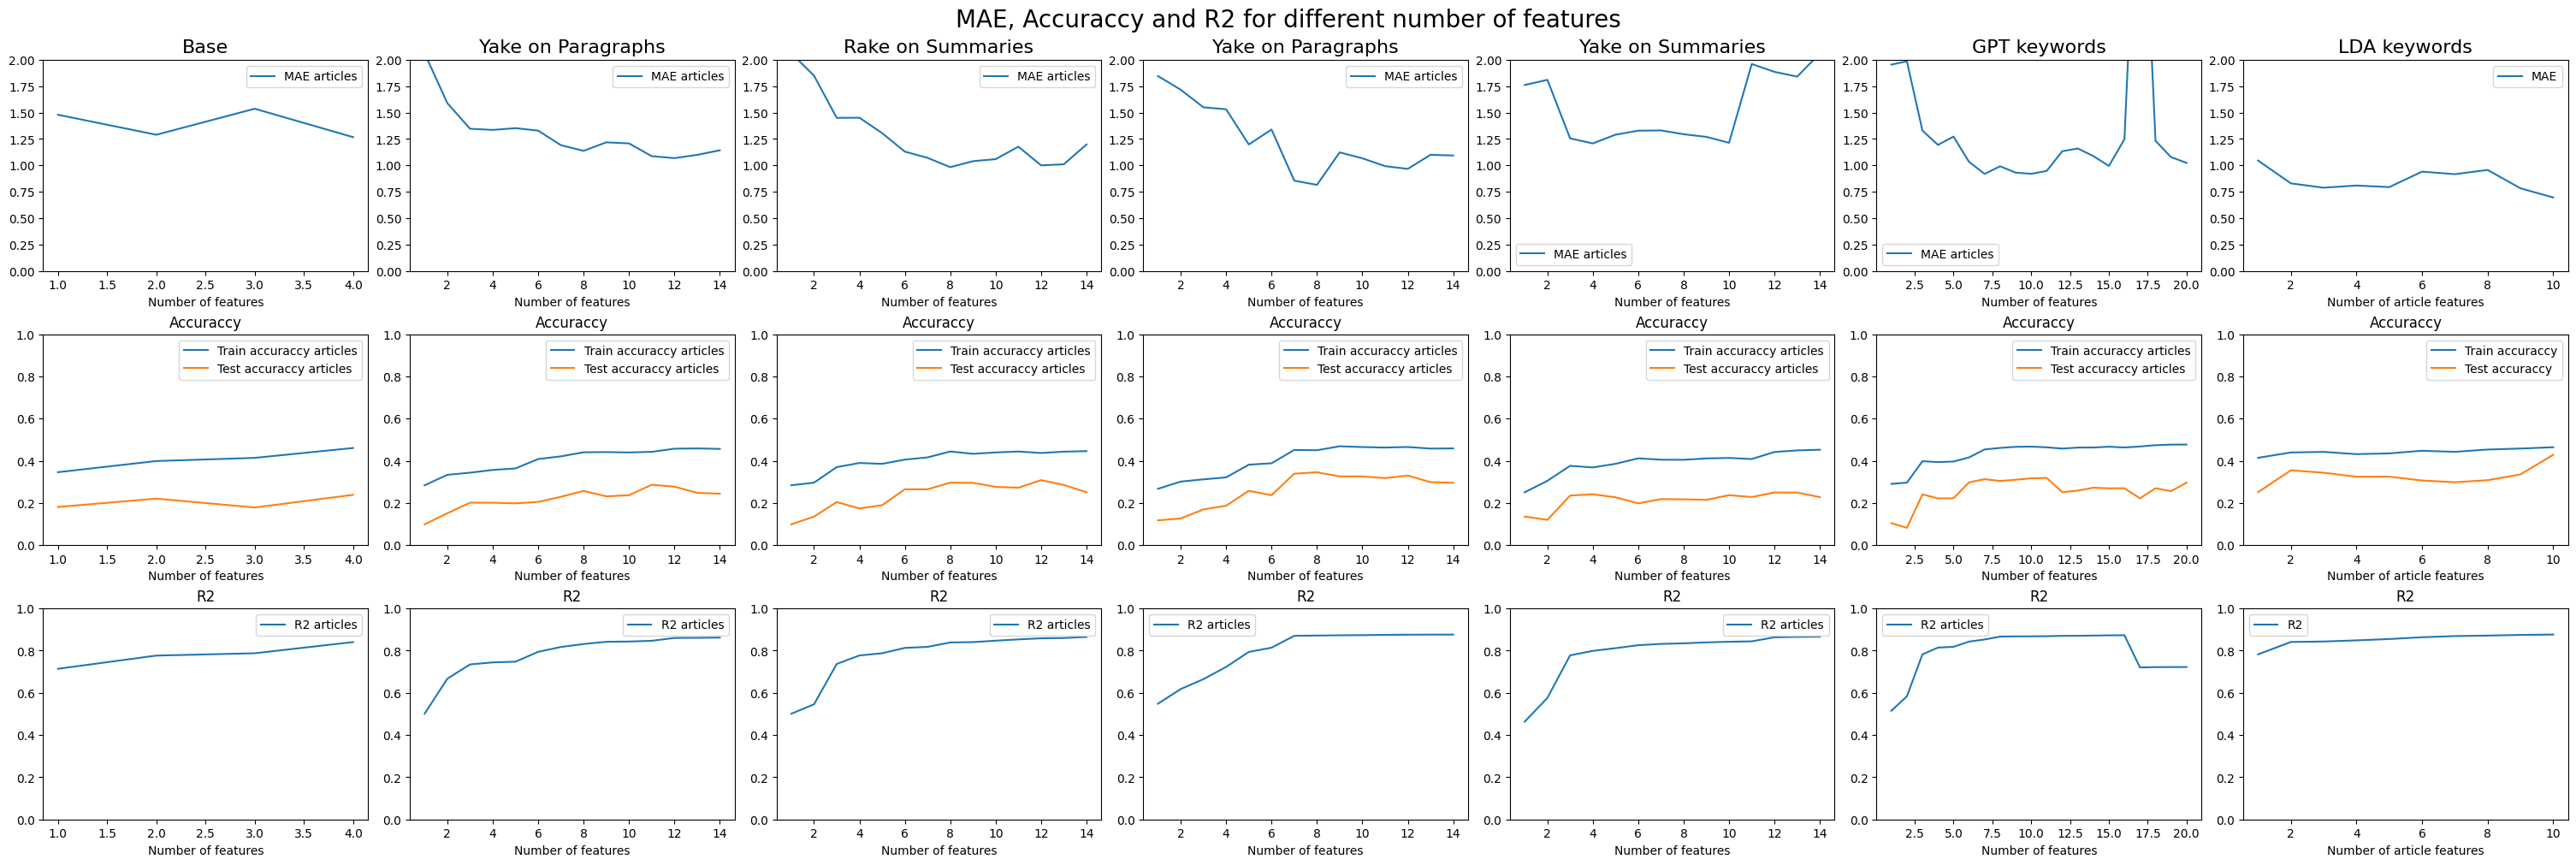

In [ ]:
#offset xvals for plotting
base_article_xvals = [i for i in range(1, 5)]
article_xvals = [i for i in range(1, 15)]
gpt_article_xvals = [i for i in range(1, 21)]
lda_article_xvals = [i for i in range(1, 11)]

#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(30, 10), constrained_layout=True)

axis[0,0].plot(base_article_xvals, base_mae_values_articles, label='MAE articles')
axis[2,0].plot(base_article_xvals, base_r2_values_articles, label='R2 articles')
axis[1,0].plot(base_article_xvals, base_train_accuracy_articles, label='Train accuraccy articles')
axis[1,0].plot(base_article_xvals, base_test_accuracy_articles, label='Test accuraccy articles')
axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[0,0].set_title('MAE')
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of features')
axis[1,0].set_xlabel('Number of features')
axis[2,0].set_xlabel('Number of features')
axis[0,0].set_ylim(0, 2)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(article_xvals, rp_mae_values_articles, label='MAE articles')
axis[2,1].plot(article_xvals, rp_r2_values_articles, label='R2 articles')
axis[1,1].plot(article_xvals, rp_train_accuracy_articles, label='Train accuraccy articles')
axis[1,1].plot(article_xvals, rp_test_accuracy_articles, label='Test accuraccy articles')
axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[0,1].set_title('MAE')
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of features')
axis[1,1].set_xlabel('Number of features')
axis[2,1].set_xlabel('Number of features')
axis[0,1].set_ylim(0, 2)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(article_xvals, rs_mae_values_articles, label='MAE articles')
axis[2,2].plot(article_xvals, rs_r2_values_articles, label='R2 articles')
axis[1,2].plot(article_xvals, rs_train_accuracy_articles, label='Train accuraccy articles')
axis[1,2].plot(article_xvals, rs_test_accuracy_articles, label='Test accuraccy articles')
axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[0,2].set_title('MAE')
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of features')
axis[1,2].set_xlabel('Number of features')
axis[2,2].set_xlabel('Number of features')
axis[0,2].set_ylim(0, 2)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(article_xvals, yp_mae_values_articles, label='MAE articles')
axis[2,3].plot(article_xvals, yp_r2_values_articles, label='R2 articles')
axis[1,3].plot(article_xvals, yp_train_accuracy_articles, label='Train accuraccy articles')
axis[1,3].plot(article_xvals, yp_test_accuracy_articles, label='Test accuraccy articles')
axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of features')
axis[1,3].set_xlabel('Number of features')
axis[2,3].set_xlabel('Number of features')
axis[0,3].set_ylim(0, 2)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(article_xvals, ys_mae_values_articles, label='MAE articles')
axis[2,4].plot(article_xvals, ys_r2_values_articles, label='R2 articles')
axis[1,4].plot(article_xvals, ys_train_accuracy_articles, label='Train accuraccy articles')
axis[1,4].plot(article_xvals, ys_test_accuracy_articles, label='Test accuraccy articles')
axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[0,4].set_title('MAE')
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of features')
axis[1,4].set_xlabel('Number of features')
axis[2,4].set_xlabel('Number of features')
axis[0,4].set_ylim(0, 2)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_article_xvals, gpt_mae_values_articles, label='MAE articles')
axis[2,5].plot(gpt_article_xvals, gpt_r2_values_articles, label='R2 articles')
axis[1,5].plot(gpt_article_xvals, gpt_train_accuracy_articles, label='Train accuraccy articles')
axis[1,5].plot(gpt_article_xvals, gpt_test_accuracy_articles, label='Test accuraccy articles')
axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[0,5].set_title('MAE')
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of features')
axis[1,5].set_xlabel('Number of features')
axis[2,5].set_xlabel('Number of features')
axis[0,5].set_ylim(0, 2)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_article_xvals, lda_mae_values_articles, label='MAE')
axis[2,6].plot(lda_article_xvals, lda_r2_values_articles, label='R2')
axis[1,6].plot(lda_article_xvals, lda_train_accuracy_articles, label='Train accuraccy')
axis[1,6].plot(lda_article_xvals, lda_test_accuracy_articles, label='Test accuraccy')
axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[0,6].set_title('MAE')
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 2)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20)

## Combined plot

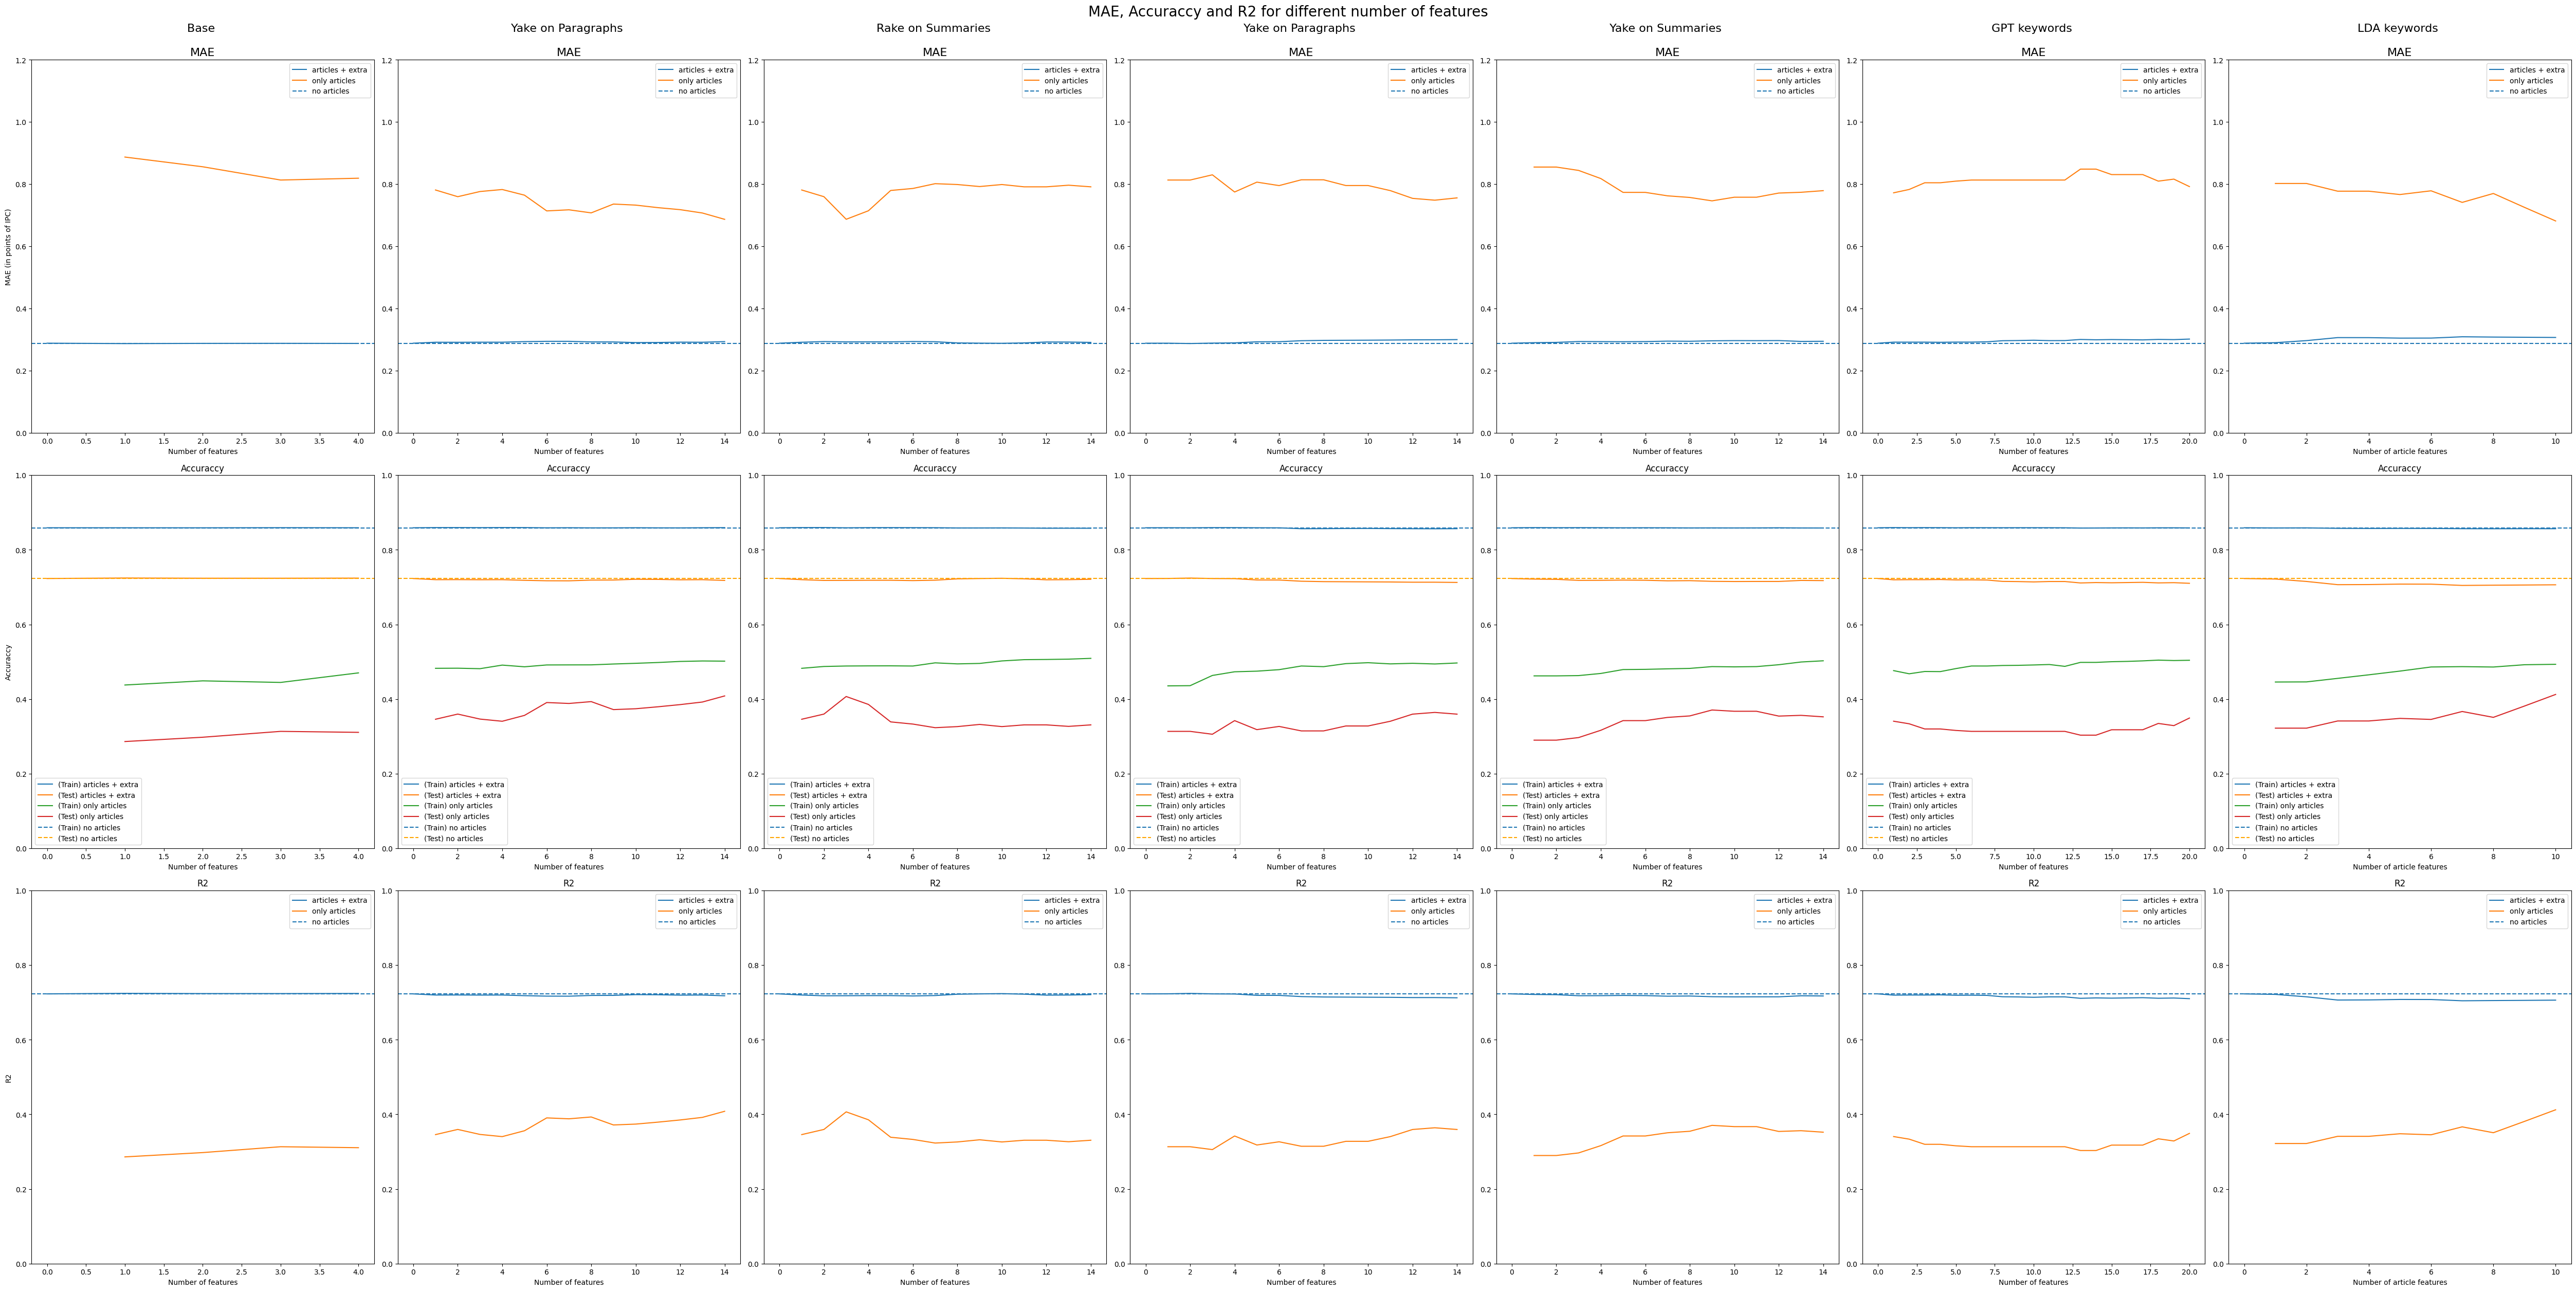

In [ ]:
#offset xvals for plotting
base_article_xvals = [i for i in range(1, 5)]
article_xvals = [i for i in range(1, 15)]
gpt_article_xvals = [i for i in range(1, 21)]
lda_article_xvals = [i for i in range(1, 11)]

#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(50, 25), constrained_layout=True)

axis[0,0].plot(base_mae_values, label='articles + extra')
axis[2,0].plot(base_r2_values, label='articles + extra')
axis[1,0].plot(base_train_accuracy, label='(Train) articles + extra')
axis[1,0].plot(base_test_accuracy, label='(Test) articles + extra')

axis[0,0].plot(base_article_xvals, base_mae_values_articles, label='only articles')
axis[2,0].plot(base_article_xvals, base_r2_values_articles, label='only articles')
axis[1,0].plot(base_article_xvals, base_train_accuracy_articles, label='(Train) only articles')
axis[1,0].plot(base_article_xvals, base_test_accuracy_articles, label='(Test) only articles')

axis[0,0].axhline(base_mae_values[0], linestyle='--', label='no articles')
axis[2,0].axhline(base_r2_values[0], linestyle='--', label='no articles')
axis[1,0].axhline(base_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,0].axhline(base_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of features')
axis[1,0].set_xlabel('Number of features')
axis[2,0].set_xlabel('Number of features')
axis[0,0].set_ylabel('MAE (in points of IPC)')
axis[1,0].set_ylabel('Accuraccy')
axis[2,0].set_ylabel('R2')
axis[0,0].set_ylim(0, 1.2)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(rp_mae_values, label='articles + extra')
axis[2,1].plot(rp_r2_values, label='articles + extra')
axis[1,1].plot(rp_train_accuracy, label='(Train) articles + extra')
axis[1,1].plot(rp_test_accuracy, label='(Test) articles + extra')

axis[0,1].plot(article_xvals, rp_mae_values_articles, label='only articles')
axis[2,1].plot(article_xvals, rp_r2_values_articles, label='only articles')
axis[1,1].plot(article_xvals, rp_train_accuracy_articles, label='(Train) only articles')
axis[1,1].plot(article_xvals, rp_test_accuracy_articles, label='(Test) only articles')

axis[0,1].axhline(rp_mae_values[0], linestyle='--', label='no articles')
axis[2,1].axhline(rp_r2_values[0], linestyle='--', label='no articles')
axis[1,1].axhline(rp_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,1].axhline(rp_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of features')
axis[1,1].set_xlabel('Number of features')
axis[2,1].set_xlabel('Number of features')
axis[0,1].set_ylim(0, 1.2)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(rs_mae_values, label='articles + extra')
axis[2,2].plot(rs_r2_values, label='articles + extra')
axis[1,2].plot(rs_train_accuracy, label='(Train) articles + extra')
axis[1,2].plot(rs_test_accuracy, label='(Test) articles + extra')

axis[0,2].plot(article_xvals, rs_mae_values_articles, label='only articles')
axis[2,2].plot(article_xvals, rs_r2_values_articles, label='only articles')
axis[1,2].plot(article_xvals, rs_train_accuracy_articles, label='(Train) only articles')
axis[1,2].plot(article_xvals, rs_test_accuracy_articles, label='(Test) only articles')

axis[0,2].axhline(rs_mae_values[0], linestyle='--', label='no articles')
axis[2,2].axhline(rs_r2_values[0], linestyle='--', label='no articles')
axis[1,2].axhline(rs_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,2].axhline(rs_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of features')
axis[1,2].set_xlabel('Number of features')
axis[2,2].set_xlabel('Number of features')
axis[0,2].set_ylim(0, 1.2)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(yp_mae_values, label='articles + extra')
axis[2,3].plot(yp_r2_values, label='articles + extra')
axis[1,3].plot(yp_train_accuracy, label='(Train) articles + extra')
axis[1,3].plot(yp_test_accuracy, label='(Test) articles + extra')

axis[0,3].plot(article_xvals, yp_mae_values_articles, label='only articles')
axis[2,3].plot(article_xvals, yp_r2_values_articles, label='only articles')
axis[1,3].plot(article_xvals, yp_train_accuracy_articles, label='(Train) only articles')
axis[1,3].plot(article_xvals, yp_test_accuracy_articles, label='(Test) only articles')

axis[0,3].axhline(yp_mae_values[0], linestyle='--', label='no articles')
axis[2,3].axhline(yp_r2_values[0], linestyle='--', label='no articles')
axis[1,3].axhline(yp_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,3].axhline(yp_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of features')
axis[1,3].set_xlabel('Number of features')
axis[2,3].set_xlabel('Number of features')
axis[0,3].set_ylim(0, 1.2)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(ys_mae_values, label='articles + extra')
axis[2,4].plot(ys_r2_values, label='articles + extra')
axis[1,4].plot(ys_train_accuracy, label='(Train) articles + extra')
axis[1,4].plot(ys_test_accuracy, label='(Test) articles + extra')

axis[0,4].plot(article_xvals, ys_mae_values_articles, label='only articles')
axis[2,4].plot(article_xvals, ys_r2_values_articles, label='only articles')
axis[1,4].plot(article_xvals, ys_train_accuracy_articles, label='(Train) only articles')
axis[1,4].plot(article_xvals, ys_test_accuracy_articles, label='(Test) only articles')

axis[0,4].axhline(ys_mae_values[0], linestyle='--', label='no articles')
axis[2,4].axhline(ys_r2_values[0], linestyle='--', label='no articles')
axis[1,4].axhline(ys_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,4].axhline(ys_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of features')
axis[1,4].set_xlabel('Number of features')
axis[2,4].set_xlabel('Number of features')
axis[0,4].set_ylim(0, 1.2)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_mae_values, label='articles + extra')
axis[2,5].plot(gpt_r2_values, label='articles + extra')
axis[1,5].plot(gpt_train_accuracy, label='(Train) articles + extra')
axis[1,5].plot(gpt_test_accuracy, label='(Test) articles + extra')

axis[0,5].plot(gpt_article_xvals, gpt_mae_values_articles, label='only articles')
axis[2,5].plot(gpt_article_xvals, gpt_r2_values_articles, label='only articles')
axis[1,5].plot(gpt_article_xvals, gpt_train_accuracy_articles, label='(Train) only articles')
axis[1,5].plot(gpt_article_xvals, gpt_test_accuracy_articles, label='(Test) only articles')

#create horizontal lines for no articles to see if there is an improvement
axis[0,5].axhline(gpt_mae_values[0], linestyle='--', label='no articles')
axis[2,5].axhline(gpt_r2_values[0], linestyle='--', label='no articles')
axis[1,5].axhline(gpt_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,5].axhline(gpt_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of features')
axis[1,5].set_xlabel('Number of features')
axis[2,5].set_xlabel('Number of features')
axis[0,5].set_ylim(0, 1.2)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords \n\nMAE', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_mae_values, label='articles + extra')
axis[2,6].plot(lda_r2_values, label='articles + extra')
axis[1,6].plot(lda_train_accuracy, label='(Train) articles + extra')
axis[1,6].plot(lda_test_accuracy, label='(Test) articles + extra')

axis[0,6].plot(lda_article_xvals, lda_mae_values_articles, label='only articles')
axis[2,6].plot(lda_article_xvals, lda_r2_values_articles, label='only articles')
axis[1,6].plot(lda_article_xvals, lda_train_accuracy_articles, label='(Train) only articles')
axis[1,6].plot(lda_article_xvals, lda_test_accuracy_articles, label='(Test) only articles')

#create horizontal lines for no articles to see if there is an improvement
axis[0,6].axhline(lda_mae_values[0], linestyle='--', label='no articles')
axis[2,6].axhline(lda_r2_values[0], linestyle='--', label='no articles')
axis[1,6].axhline(lda_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,6].axhline(lda_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 1.2)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords \n\nMAE', fontsize=16);

plt.savefig('bigone.png', format='png', dpi=100)

# OLS

## Topics + Baseline features

In [ ]:
def train_model_only_articles(features_df):

    ndf = df.copy()
    ndf.sort_index(level=0, inplace=True) # Sort DataFrame by date
    ndf = ndf.iloc[ndf['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
    ndf = ndf.join(features_df, how="left") # Join df with created news features
    ndf = ndf.iloc[ndf.iloc[:,-1].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
    ndf.dropna(subset=ndf.iloc[:,-len(features_df.columns):].columns, inplace=True)
    ndf = ndf[ndf['ipc'] != 5]

    all_mae_values = list()
    all_r2_values = list()
    all_train_accuraccy = list()
    all_test_accuraccy = list()

    for i in range(len(features_df.columns)+1):  # +1 for 0 topics
        start = -len(features_df.columns) - 6  # -6 is for baseline features.
        end = -len(features_df.columns) + i
        print(f"Start: {start}, End: {end}")
        if end == 0:
            X = ndf.iloc[:, start:] # Define explanatory variables
        else:
            X = ndf.iloc[:, start:(end)] # Define explanatory variables
        y = ndf[["ipc"]] # Define target data

        cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

        # Initinalize empty lists to score scores
        mae_values = list()
        r2_values = list()
        train_accuraccy = list()
        test_accuraccy = list()

        for train_index, val_index in cv.split(X): # Loop over the different training-test splits

            # Define X and y data
            X_train, X_test = X.iloc[train_index], X.iloc[val_index]
            y_train, y_test = y.iloc[train_index], y.iloc[val_index]

            # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
            X_train = X_train.dropna(axis=1, how='all').copy()
            X_test = X_test[X_train.columns]
            
            #Interpolate training data to generate more training points
            X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.ffill())
            X_train.reset_index(level=0, drop=True, inplace=True)
            y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.ffill())
            y_train.reset_index(level=0, drop=True, inplace=True)

            model = OLS(y_train, X_train, missing="drop")

            results = model.fit() # Get model results on training data
            #print(results.summary()) # Print model summary

            y_pred_test = results.predict(X_test) # Run model on test data
            y_pred_train = results.predict(X_train) # Run model on test data
            
            # Append results to respective lists
            mae_values.append(metrics.mean_absolute_error(y_test, y_pred_test))
            # r2_values.append(results.rsquared)

            # plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
            # plot_ConfusionMatrix(prediction = y_pred_test, true = y_test['ipc']) # Plot confusion matrix

            # Calculate accuraccy
            train_correct = ((y_pred_train.round()==y_train['ipc']).sum()) # ammount of correct train predictions
            test_correct = ((y_pred_test.round()==y_test['ipc']).sum()) # ammount of correct test predictions
            train_values_count = len(y_train['ipc'])-y_pred_train.round().isna().sum() # train values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
            test_values_count = len(y_test['ipc'])-y_test['ipc'].isna().sum() # test values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
        
            # Append accuraccy to respective lists
            train_accuraccy.append(train_correct/train_values_count)
            test_accuraccy.append(test_correct/test_values_count)

            r2_values.append(results.rsquared)
        
        print(f"Number of features: {len(X.columns)-1}")
        print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
        print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
        print(f"Mean train accuraccy: {np.mean(train_accuraccy):.2f}") # Print train accuraccy
        print(f"Mean test accuraccy: {np.mean(test_accuraccy):.2f}") # Print test accuraccy
        print(f"Mean train accuraccy: {np.mean(train_accuraccy)}") # Print train accuraccy
        print(f"Mean test accuraccy: {np.mean(test_accuraccy)}")
        print('-------------------------')

        all_mae_values.append(np.mean(mae_values))
        all_r2_values.append(np.mean(r2_values))
        all_train_accuraccy.append(np.mean(train_accuraccy))
        all_test_accuraccy.append(np.mean(test_accuraccy))
    print("")
    print(f"All MAE values: {all_mae_values}")
    print(f"All R2 values: {all_r2_values}")
    print(f"All train accuracy values: {all_train_accuraccy}")
    print(f"All test accuracy values: {all_test_accuraccy}")
    return all_mae_values, all_r2_values, all_train_accuraccy, all_test_accuraccy

### Running models

In [ ]:
base_mae_values, base_r2_values, base_train_accuracy, base_test_accuracy = train_model(news_features_base)
lda_mae_values, lda_r2_values, lda_train_accuracy, lda_test_accuracy = train_model(news_features_lda)
rp_mae_values, rp_r2_values, rp_train_accuracy, rp_test_accuracy = train_model(news_features_rp)
rs_mae_values, rs_r2_values, rs_train_accuracy, rs_test_accuracy = train_model(news_features_rs)
yp_mae_values, yp_r2_values, yp_train_accuracy, yp_test_accuracy = train_model(news_features_yp)
ys_mae_values, ys_r2_values, ys_train_accuracy, ys_test_accuracy = train_model(news_features_ys)
gpt_mae_values, gpt_r2_values, gpt_train_accuracy, gpt_test_accuracy = train_model(news_features_gpt)

### plotting topics + baseline features

In [ ]:
#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(30, 10), constrained_layout=True)

axis[0,0].plot(base_mae_values, label='MAE')
axis[2,0].plot(base_r2_values, label='R2')
axis[1,0].plot(base_train_accuracy, label='Train accuraccy')
axis[1,0].plot(base_test_accuracy, label='Test accuraccy')
axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[0,0].set_title('MAE')
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of article features')
axis[1,0].set_xlabel('Number of article features')
axis[2,0].set_xlabel('Number of article features')
axis[0,0].set_ylim(0, 1)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(yp_mae_values, label='MAE')
axis[2,1].plot(yp_r2_values, label='R2')
axis[1,1].plot(yp_train_accuracy, label='Train accuraccy')
axis[1,1].plot(yp_test_accuracy, label='Test accuraccy')
axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[0,1].set_title('MAE')
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of article features')
axis[1,1].set_xlabel('Number of article features')
axis[2,1].set_xlabel('Number of article features')
axis[0,1].set_ylim(0, 1)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(rs_mae_values, label='MAE')
axis[2,2].plot(rs_r2_values, label='R2')
axis[1,2].plot(rs_train_accuracy, label='Train accuraccy')
axis[1,2].plot(rs_test_accuracy, label='Test accuraccy')
axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[0,2].set_title('MAE')
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of article features')
axis[1,2].set_xlabel('Number of article features')
axis[2,2].set_xlabel('Number of article features')
axis[0,2].set_ylim(0, 1)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(yp_mae_values, label='MAE')
axis[2,3].plot(yp_r2_values, label='R2')
axis[1,3].plot(yp_train_accuracy, label='Train accuraccy')
axis[1,3].plot(yp_test_accuracy, label='Test accuraccy')
axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of article features')
axis[1,3].set_xlabel('Number of article features')
axis[2,3].set_xlabel('Number of article features')
axis[0,3].set_ylim(0, 1)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(ys_mae_values, label='MAE')
axis[2,4].plot(ys_r2_values, label='R2')
axis[1,4].plot(ys_train_accuracy, label='Train accuraccy')
axis[1,4].plot(ys_test_accuracy, label='Test accuraccy')
axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[0,4].set_title('MAE')
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of article features')
axis[1,4].set_xlabel('Number of article features')
axis[2,4].set_xlabel('Number of article features')
axis[0,4].set_ylim(0, 1)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_mae_values, label='MAE')
axis[2,5].plot(gpt_r2_values, label='R2')
axis[1,5].plot(gpt_train_accuracy, label='Train accuraccy')
axis[1,5].plot(gpt_test_accuracy, label='Test accuraccy')
axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[0,5].set_title('MAE')
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of article features')
axis[1,5].set_xlabel('Number of article features')
axis[2,5].set_xlabel('Number of article features')
axis[0,5].set_ylim(0, 1)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_mae_values, label='MAE')
axis[2,6].plot(lda_r2_values, label='R2')
axis[1,6].plot(lda_train_accuracy, label='Train accuraccy')
axis[1,6].plot(lda_test_accuracy, label='Test accuraccy')
axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[0,6].set_title('MAE')
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 1)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

## Only Topics

In [ ]:
def train_model_only_articles(features_df):

    ndf = df.copy()
    ndf.sort_index(level=0, inplace=True) # Sort DataFrame by date
    ndf = ndf.iloc[ndf['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
    ndf = ndf.join(features_df, how="left") # Join df with created news features
    ndf = ndf.iloc[ndf.iloc[:,-1].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
    ndf.dropna(subset=ndf.iloc[:,-len(features_df.columns):].columns, inplace=True)
    ndf = ndf[ndf['ipc'] != 5]

    all_mae_values = list()
    all_r2_values = list()
    all_train_accuraccy = list()
    all_test_accuraccy = list()

    for i in range(len(features_df.columns)):
        start = -len(features_df.columns)
        end = -len(features_df.columns) + i + 1
        print(f"Start: {start}, End: {end}")
        if end == 0:
            X = ndf.iloc[:, start:] # Define explanatory variables
        else:
            X = ndf.iloc[:, start:(end)] # Define explanatory variables
        y = ndf[["ipc"]] # Define target data

        cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

        # Initinalize empty lists to score scores
        mae_values = list()
        r2_values = list()
        train_accuraccy = list()
        test_accuraccy = list()

        for train_index, val_index in cv.split(X): # Loop over the different training-test splits

            # Define X and y data
            X_train, X_test = X.iloc[train_index], X.iloc[val_index]
            y_train, y_test = y.iloc[train_index], y.iloc[val_index]

            # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
            X_train = X_train.dropna(axis=1, how='all').copy()
            X_test = X_test[X_train.columns]
            
            #Interpolate training data to generate more training points
            X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.ffill())
            X_train.reset_index(level=0, drop=True, inplace=True)
            y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.ffill())
            y_train.reset_index(level=0, drop=True, inplace=True)

            model = OLS(y_train, X_train, missing="drop")

            results = model.fit() # Get model results on training data
            #print(results.summary()) # Print model summary

            y_pred_test = results.predict(X_test) # Run model on test data
            y_pred_train = results.predict(X_train) # Run model on test data
            
            # Append results to respective lists
            mae_values.append(metrics.mean_absolute_error(y_test, y_pred_test))
            # r2_values.append(results.rsquared)

            # plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
            # plot_ConfusionMatrix(prediction = y_pred_test, true = y_test['ipc']) # Plot confusion matrix

            # Calculate accuraccy
            train_correct = ((y_pred_train.round()==y_train['ipc']).sum()) # ammount of correct train predictions
            test_correct = ((y_pred_test.round()==y_test['ipc']).sum()) # ammount of correct test predictions
            train_values_count = len(y_train['ipc'])-y_pred_train.round().isna().sum() # train values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
            test_values_count = len(y_test['ipc'])-y_test['ipc'].isna().sum() # test values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
        
            # Append accuraccy to respective lists
            train_accuraccy.append(train_correct/train_values_count)
            test_accuraccy.append(test_correct/test_values_count)

            r2_values.append(results.rsquared)
        
        print(f"Number of features: {len(X.columns)-1}")
        print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
        print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
        print(f"Mean train accuraccy: {np.mean(train_accuraccy):.2f}") # Print train accuraccy
        print(f"Mean test accuraccy: {np.mean(test_accuraccy):.2f}") # Print test accuraccy
        print(f"Mean train accuraccy: {np.mean(train_accuraccy)}") # Print train accuraccy
        print(f"Mean test accuraccy: {np.mean(test_accuraccy)}")
        print('-------------------------')

        all_mae_values.append(np.mean(mae_values))
        all_r2_values.append(np.mean(r2_values))
        all_train_accuraccy.append(np.mean(train_accuraccy))
        all_test_accuraccy.append(np.mean(test_accuraccy))
    print("")
    print(f"All MAE values: {all_mae_values}")
    print(f"All R2 values: {all_r2_values}")
    print(f"All train accuracy values: {all_train_accuraccy}")
    print(f"All test accuracy values: {all_test_accuraccy}")
    return all_mae_values, all_r2_values, all_train_accuraccy, all_test_accuraccy

### Running models

In [ ]:
base_mae_values_articles, base_r2_values_articles, base_train_accuracy_articles, base_test_accuracy_articles = train_model_only_articles(news_features_base)
rp_mae_values_articles, rp_r2_values_articles, rp_train_accuracy_articles, rp_test_accuracy_articles = train_model_only_articles(news_features_rp)
rs_mae_values_articles, rs_r2_values_articles, rs_train_accuracy_articles, rs_test_accuracy_articles = train_model_only_articles(news_features_rs)
rs_mae_values_articles, rs_r2_values_articles, rs_train_accuracy_articles, rs_test_accuracy_articles = train_model_only_articles(news_features_rs)
yp_mae_values_articles, yp_r2_values_articles, yp_train_accuracy_articles, yp_test_accuracy_articles = train_model_only_articles(news_features_yp)
ys_mae_values_articles, ys_r2_values_articles, ys_train_accuracy_articles, ys_test_accuracy_articles = train_model_only_articles(news_features_ys)
gpt_mae_values_articles, gpt_r2_values_articles, gpt_train_accuracy_articles, gpt_test_accuracy_articles = train_model_only_articles(news_features_gpt)
lda_mae_values_articles, lda_r2_values_articles, lda_train_accuracy_articles, lda_test_accuracy_articles = train_model_only_articles(news_features_lda)

### Plotting only topics

In [ ]:
#offset xvals for plotting
base_article_xvals = [i for i in range(1, 5)]
article_xvals = [i for i in range(1, 15)]
gpt_article_xvals = [i for i in range(1, 21)]
lda_article_xvals = [i for i in range(1, 11)]

#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(30, 10), constrained_layout=True)

axis[0,0].plot(base_article_xvals, base_mae_values_articles, label='MAE articles')
axis[2,0].plot(base_article_xvals, base_r2_values_articles, label='R2 articles')
axis[1,0].plot(base_article_xvals, base_train_accuracy_articles, label='Train accuraccy articles')
axis[1,0].plot(base_article_xvals, base_test_accuracy_articles, label='Test accuraccy articles')
axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[0,0].set_title('MAE')
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of features')
axis[1,0].set_xlabel('Number of features')
axis[2,0].set_xlabel('Number of features')
axis[0,0].set_ylim(0, 2)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(article_xvals, rp_mae_values_articles, label='MAE articles')
axis[2,1].plot(article_xvals, rp_r2_values_articles, label='R2 articles')
axis[1,1].plot(article_xvals, rp_train_accuracy_articles, label='Train accuraccy articles')
axis[1,1].plot(article_xvals, rp_test_accuracy_articles, label='Test accuraccy articles')
axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[0,1].set_title('MAE')
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of features')
axis[1,1].set_xlabel('Number of features')
axis[2,1].set_xlabel('Number of features')
axis[0,1].set_ylim(0, 2)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(article_xvals, rs_mae_values_articles, label='MAE articles')
axis[2,2].plot(article_xvals, rs_r2_values_articles, label='R2 articles')
axis[1,2].plot(article_xvals, rs_train_accuracy_articles, label='Train accuraccy articles')
axis[1,2].plot(article_xvals, rs_test_accuracy_articles, label='Test accuraccy articles')
axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[0,2].set_title('MAE')
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of features')
axis[1,2].set_xlabel('Number of features')
axis[2,2].set_xlabel('Number of features')
axis[0,2].set_ylim(0, 2)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(article_xvals, yp_mae_values_articles, label='MAE articles')
axis[2,3].plot(article_xvals, yp_r2_values_articles, label='R2 articles')
axis[1,3].plot(article_xvals, yp_train_accuracy_articles, label='Train accuraccy articles')
axis[1,3].plot(article_xvals, yp_test_accuracy_articles, label='Test accuraccy articles')
axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of features')
axis[1,3].set_xlabel('Number of features')
axis[2,3].set_xlabel('Number of features')
axis[0,3].set_ylim(0, 2)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(article_xvals, ys_mae_values_articles, label='MAE articles')
axis[2,4].plot(article_xvals, ys_r2_values_articles, label='R2 articles')
axis[1,4].plot(article_xvals, ys_train_accuracy_articles, label='Train accuraccy articles')
axis[1,4].plot(article_xvals, ys_test_accuracy_articles, label='Test accuraccy articles')
axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[0,4].set_title('MAE')
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of features')
axis[1,4].set_xlabel('Number of features')
axis[2,4].set_xlabel('Number of features')
axis[0,4].set_ylim(0, 2)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_article_xvals, gpt_mae_values_articles, label='MAE articles')
axis[2,5].plot(gpt_article_xvals, gpt_r2_values_articles, label='R2 articles')
axis[1,5].plot(gpt_article_xvals, gpt_train_accuracy_articles, label='Train accuraccy articles')
axis[1,5].plot(gpt_article_xvals, gpt_test_accuracy_articles, label='Test accuraccy articles')
axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[0,5].set_title('MAE')
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of features')
axis[1,5].set_xlabel('Number of features')
axis[2,5].set_xlabel('Number of features')
axis[0,5].set_ylim(0, 2)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_article_xvals, lda_mae_values_articles, label='MAE')
axis[2,6].plot(lda_article_xvals, lda_r2_values_articles, label='R2')
axis[1,6].plot(lda_article_xvals, lda_train_accuracy_articles, label='Train accuraccy')
axis[1,6].plot(lda_article_xvals, lda_test_accuracy_articles, label='Test accuraccy')
axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[0,6].set_title('MAE')
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 2)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20)

## Combined plot

In [ ]:
#offset xvals for plotting
base_article_xvals = [i for i in range(1, 5)]
article_xvals = [i for i in range(1, 15)]
gpt_article_xvals = [i for i in range(1, 21)]
lda_article_xvals = [i for i in range(1, 11)]

#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(50, 25), constrained_layout=True)

axis[0,0].plot(base_mae_values, label='articles + extra')
axis[2,0].plot(base_r2_values, label='articles + extra')
axis[1,0].plot(base_train_accuracy, label='(Train) articles + extra')
axis[1,0].plot(base_test_accuracy, label='(Test) articles + extra')

axis[0,0].plot(base_article_xvals, base_mae_values_articles, label='only articles')
axis[2,0].plot(base_article_xvals, base_r2_values_articles, label='only articles')
axis[1,0].plot(base_article_xvals, base_train_accuracy_articles, label='(Train) only articles')
axis[1,0].plot(base_article_xvals, base_test_accuracy_articles, label='(Test) only articles')

axis[0,0].axhline(base_mae_values[0], linestyle='--', label='no articles')
axis[2,0].axhline(base_r2_values[0], linestyle='--', label='no articles')
axis[1,0].axhline(base_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,0].axhline(base_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of features')
axis[1,0].set_xlabel('Number of features')
axis[2,0].set_xlabel('Number of features')
axis[0,0].set_ylabel('MAE (in points of IPC)')
axis[1,0].set_ylabel('Accuraccy')
axis[2,0].set_ylabel('R2')
axis[0,0].set_ylim(0, 1.2)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(rp_mae_values, label='articles + extra')
axis[2,1].plot(rp_r2_values, label='articles + extra')
axis[1,1].plot(rp_train_accuracy, label='(Train) articles + extra')
axis[1,1].plot(rp_test_accuracy, label='(Test) articles + extra')

axis[0,1].plot(article_xvals, rp_mae_values_articles, label='only articles')
axis[2,1].plot(article_xvals, rp_r2_values_articles, label='only articles')
axis[1,1].plot(article_xvals, rp_train_accuracy_articles, label='(Train) only articles')
axis[1,1].plot(article_xvals, rp_test_accuracy_articles, label='(Test) only articles')

axis[0,1].axhline(rp_mae_values[0], linestyle='--', label='no articles')
axis[2,1].axhline(rp_r2_values[0], linestyle='--', label='no articles')
axis[1,1].axhline(rp_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,1].axhline(rp_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of features')
axis[1,1].set_xlabel('Number of features')
axis[2,1].set_xlabel('Number of features')
axis[0,1].set_ylim(0, 1.2)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(rs_mae_values, label='articles + extra')
axis[2,2].plot(rs_r2_values, label='articles + extra')
axis[1,2].plot(rs_train_accuracy, label='(Train) articles + extra')
axis[1,2].plot(rs_test_accuracy, label='(Test) articles + extra')

axis[0,2].plot(article_xvals, rs_mae_values_articles, label='only articles')
axis[2,2].plot(article_xvals, rs_r2_values_articles, label='only articles')
axis[1,2].plot(article_xvals, rs_train_accuracy_articles, label='(Train) only articles')
axis[1,2].plot(article_xvals, rs_test_accuracy_articles, label='(Test) only articles')

axis[0,2].axhline(rs_mae_values[0], linestyle='--', label='no articles')
axis[2,2].axhline(rs_r2_values[0], linestyle='--', label='no articles')
axis[1,2].axhline(rs_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,2].axhline(rs_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of features')
axis[1,2].set_xlabel('Number of features')
axis[2,2].set_xlabel('Number of features')
axis[0,2].set_ylim(0, 1.2)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(yp_mae_values, label='articles + extra')
axis[2,3].plot(yp_r2_values, label='articles + extra')
axis[1,3].plot(yp_train_accuracy, label='(Train) articles + extra')
axis[1,3].plot(yp_test_accuracy, label='(Test) articles + extra')

axis[0,3].plot(article_xvals, yp_mae_values_articles, label='only articles')
axis[2,3].plot(article_xvals, yp_r2_values_articles, label='only articles')
axis[1,3].plot(article_xvals, yp_train_accuracy_articles, label='(Train) only articles')
axis[1,3].plot(article_xvals, yp_test_accuracy_articles, label='(Test) only articles')

axis[0,3].axhline(yp_mae_values[0], linestyle='--', label='no articles')
axis[2,3].axhline(yp_r2_values[0], linestyle='--', label='no articles')
axis[1,3].axhline(yp_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,3].axhline(yp_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of features')
axis[1,3].set_xlabel('Number of features')
axis[2,3].set_xlabel('Number of features')
axis[0,3].set_ylim(0, 1.2)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(ys_mae_values, label='articles + extra')
axis[2,4].plot(ys_r2_values, label='articles + extra')
axis[1,4].plot(ys_train_accuracy, label='(Train) articles + extra')
axis[1,4].plot(ys_test_accuracy, label='(Test) articles + extra')

axis[0,4].plot(article_xvals, ys_mae_values_articles, label='only articles')
axis[2,4].plot(article_xvals, ys_r2_values_articles, label='only articles')
axis[1,4].plot(article_xvals, ys_train_accuracy_articles, label='(Train) only articles')
axis[1,4].plot(article_xvals, ys_test_accuracy_articles, label='(Test) only articles')

axis[0,4].axhline(ys_mae_values[0], linestyle='--', label='no articles')
axis[2,4].axhline(ys_r2_values[0], linestyle='--', label='no articles')
axis[1,4].axhline(ys_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,4].axhline(ys_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of features')
axis[1,4].set_xlabel('Number of features')
axis[2,4].set_xlabel('Number of features')
axis[0,4].set_ylim(0, 1.2)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_mae_values, label='articles + extra')
axis[2,5].plot(gpt_r2_values, label='articles + extra')
axis[1,5].plot(gpt_train_accuracy, label='(Train) articles + extra')
axis[1,5].plot(gpt_test_accuracy, label='(Test) articles + extra')

axis[0,5].plot(gpt_article_xvals, gpt_mae_values_articles, label='only articles')
axis[2,5].plot(gpt_article_xvals, gpt_r2_values_articles, label='only articles')
axis[1,5].plot(gpt_article_xvals, gpt_train_accuracy_articles, label='(Train) only articles')
axis[1,5].plot(gpt_article_xvals, gpt_test_accuracy_articles, label='(Test) only articles')

#create horizontal lines for no articles to see if there is an improvement
axis[0,5].axhline(gpt_mae_values[0], linestyle='--', label='no articles')
axis[2,5].axhline(gpt_r2_values[0], linestyle='--', label='no articles')
axis[1,5].axhline(gpt_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,5].axhline(gpt_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of features')
axis[1,5].set_xlabel('Number of features')
axis[2,5].set_xlabel('Number of features')
axis[0,5].set_ylim(0, 1.2)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords \n\nMAE', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_mae_values, label='articles + extra')
axis[2,6].plot(lda_r2_values, label='articles + extra')
axis[1,6].plot(lda_train_accuracy, label='(Train) articles + extra')
axis[1,6].plot(lda_test_accuracy, label='(Test) articles + extra')

axis[0,6].plot(lda_article_xvals, lda_mae_values_articles, label='only articles')
axis[2,6].plot(lda_article_xvals, lda_r2_values_articles, label='only articles')
axis[1,6].plot(lda_article_xvals, lda_train_accuracy_articles, label='(Train) only articles')
axis[1,6].plot(lda_article_xvals, lda_test_accuracy_articles, label='(Test) only articles')

#create horizontal lines for no articles to see if there is an improvement
axis[0,6].axhline(lda_mae_values[0], linestyle='--', label='no articles')
axis[2,6].axhline(lda_r2_values[0], linestyle='--', label='no articles')
axis[1,6].axhline(lda_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,6].axhline(lda_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 1.2)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords \n\nMAE', fontsize=16);

plt.savefig('bigone.png', format='png', dpi=100)